
# Setup


## Imports


In [1]:
import functools
import pathlib
from pprint import pprint
import sys
import yaml
from yaml import YAMLObject
from typing import *

import attr
import humanize
from matplotlib import pyplot as plt, cm
import numpy as np
import pandas as pd
from pymicro.file import file_utils

import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")

from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import losses

tensorflow version: 2.2.0


In [2]:
%load_ext autoreload

In [44]:
%autoreload 2
from tomo2seg import modular_unet
from tomo2seg.volume_img_segm import VolumeImgSegmSequence
from tomo2seg.logger import logger
from tomo2seg import data
from tomo2seg.data import VolumePaths, ModelPaths
from tomo2seg.metadata import Metadata

## GPUs


In [4]:
# (on R790-TOMO) 2
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [5]:
# (on R790-TOMO) CPU:0, XLA_CPU:0, GPU:0, GPU:1, XLA_GPU:0, XLA_GPU:1
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU')]

In [6]:
# (on R790-TOMO) CPU:0, XLA_CPU:0, GPU:0, GPU:1, XLA_GPU:0, XLA_GPU:1
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:GPU:1', device_type='GPU'),
 LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU'),
 LogicalDevice(name='/device:XLA_GPU:1', device_type='XLA_GPU')]

In [7]:
# set xla auto-clustering optimization
# see: https://www.tensorflow.org/xla#auto-clustering
tf.config.optimizer.set_jit(False)
# adendum: this seems to actually break the training

True

In [8]:
# get a distribution strategy to use both gpus
# see https://www.tensorflow.org/guide/distributed_training
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


# Data

## File paths


In [9]:
volume_name = data.VOLUME_PRECIPITATES_DRYRUN
volume_paths = data.volume_precipitates_dryrun

logger.info("Working with volume `%s`: %s", volume_name, volume_paths)

[2020-10-14::16:06:31.166] tomo2seg :: INFO :: {<ipython-input-9-1b32abc8a087>:<module>:004}
Working with volume `PA66GF30_trans3_x__0_pag`: VolumePaths(volume_name='PA66GF30_trans3_x__0_pag')


In [10]:
class labels:
  matrix = 0
  fiber = 1
  hole = 2

labels_list = [0, 1, 2]

dimensions = (500, 500, 500)
dtype = "uint8"  # todo remove the cast inside the generator?

# prefill the function `HST_read`
hst_read = functools.partial(
    file_utils.HST_read,
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=dtype,
    dims=dimensions,
    verbose=True,
)

## Load volumes


In [11]:
train_volume = hst_read(str(volume_paths.train_data_path))
train_labels = hst_read(str(volume_paths.train_labels_path))

val_volume = hst_read(str(volume_paths.val_data_path))
val_labels = hst_read(str(volume_paths.val_labels_path))

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


## Plot slices with labels


In [12]:
def tightsubplots(n, m, w, h):
  fig, axs = plt.subplots(n, m, figsize=(w, h), sharex=True, sharey=True)
  fig.set_tight_layout(True)
  return fig, axs

(-0.5, 499.5, 499.5, -0.5)

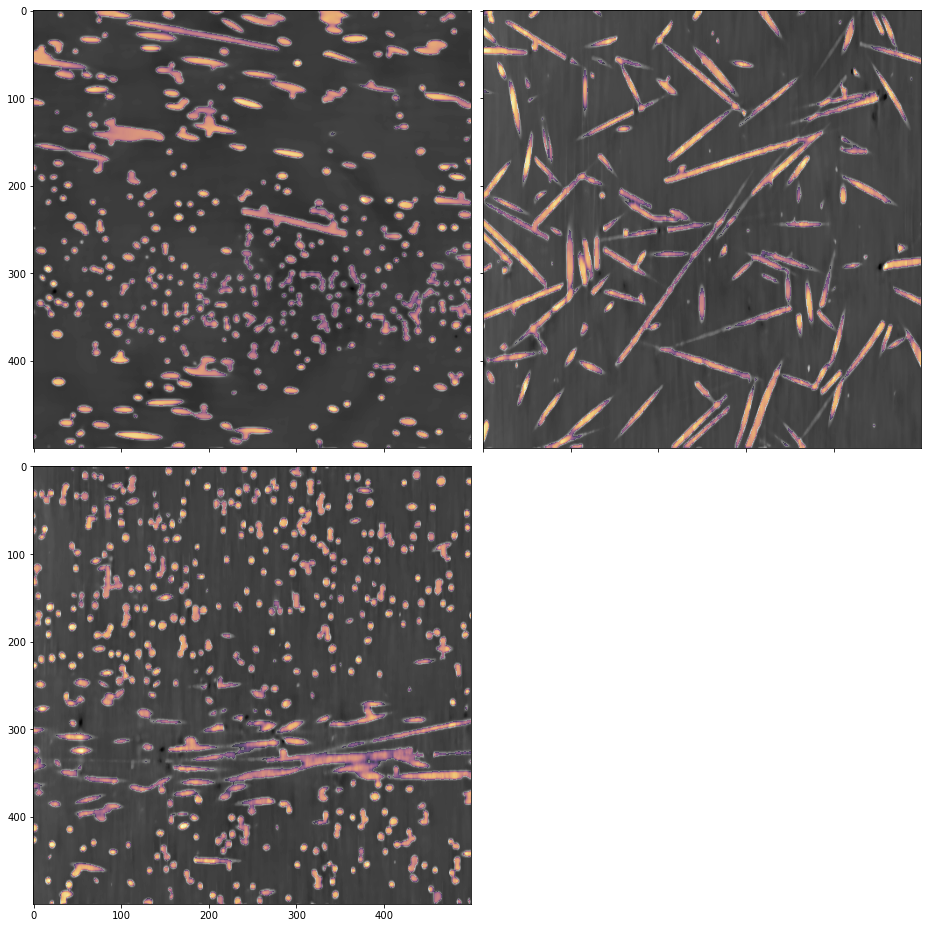

In [13]:
fig, axs = tightsubplots(2, 2, 13, 13)

volume = train_volume
mask = (~ (train_labels == labels.fiber)).astype(int)

axs[0, 0].imshow(volume[:, :, 250], cmap=cm.gray, interpolation=None)
axs[0, 1].imshow(volume[250, :, :], cmap=cm.gray)
axs[1, 0].imshow(volume[:, 250, :], cmap=cm.gray)

volume_masked = np.ma.masked_where(mask, volume)
axs[0, 0].imshow(volume_masked[:, :, 250], cmap=cm.inferno, interpolation=None, alpha=0.5)
axs[0, 1].imshow(volume_masked[250, :, :], cmap=cm.inferno, interpolation=None, alpha=0.5)
axs[1, 0].imshow(volume_masked[:, 250, :], cmap=cm.inferno, interpolation=None, alpha=0.5)

axs[1, 1].axis(False)

## Data Sequences

In [75]:
batch_size = 16
crop_size = 224  # multiple of 16 (requirement of a 4-level u-net)
n_geometric_augmentations = 4
slice_axes = (2,)

train_generator = VolumeImgSegmSequence(
    source_volume=train_volume, 
    label_volume=train_labels,
    labels=labels_list, 
    axes=slice_axes, 
    batch_size=batch_size,
    shuffle=True,
    normalization_const=255,
    n_geometric_augmentations=n_geometric_augmentations,
    random_state=42,
    crop_size=crop_size,
)

val_generator = VolumeImgSegmSequence(
    source_volume=val_volume, 
    label_volume=val_labels,
    labels=labels_list, 
    axes=(2,), 
    batch_size=10,
    shuffle=False,
    normalization_const=255,
    n_geometric_augmentations=0,
    crop_size=crop_size,
)

# Model

In [15]:
model_name = "dryrun-02"
model_paths = ModelPaths(model_name)
logger.info("Model paths object: %s", model_paths)

input_shape = (crop_size, crop_size, 1)
nb_filters_0 = 12
model_generator_function = modular_unet.u_net

[2020-10-14::16:06:47.589] tomo2seg :: INFO :: {<ipython-input-15-0c1a414601e6>:<module>:003}
Model paths object: ModelPaths(model_name='dryrun-02')


In [16]:
if not model_paths.autosaved_model_path.exists():
    assert not model_paths.model_path.exists(), f"Please delete '{model_paths.model_path}' to redefine it."

    model = model_generator_function(input_shape, nb_filters_0=nb_filters_0, output_channels=3, name=model_name)
    model.save(filepath=model_paths.model_path, overwrite=False)

else:
    logger.warning("An autosaved model already exists, loading it instead of creating a new one!")
    model = keras.models.load_model(model_paths.autosaved_model_path)
    # todo find the epoch that the training stopped at

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/users/jcasagrande/projects/tomo2seg/models/dryrun-02/assets


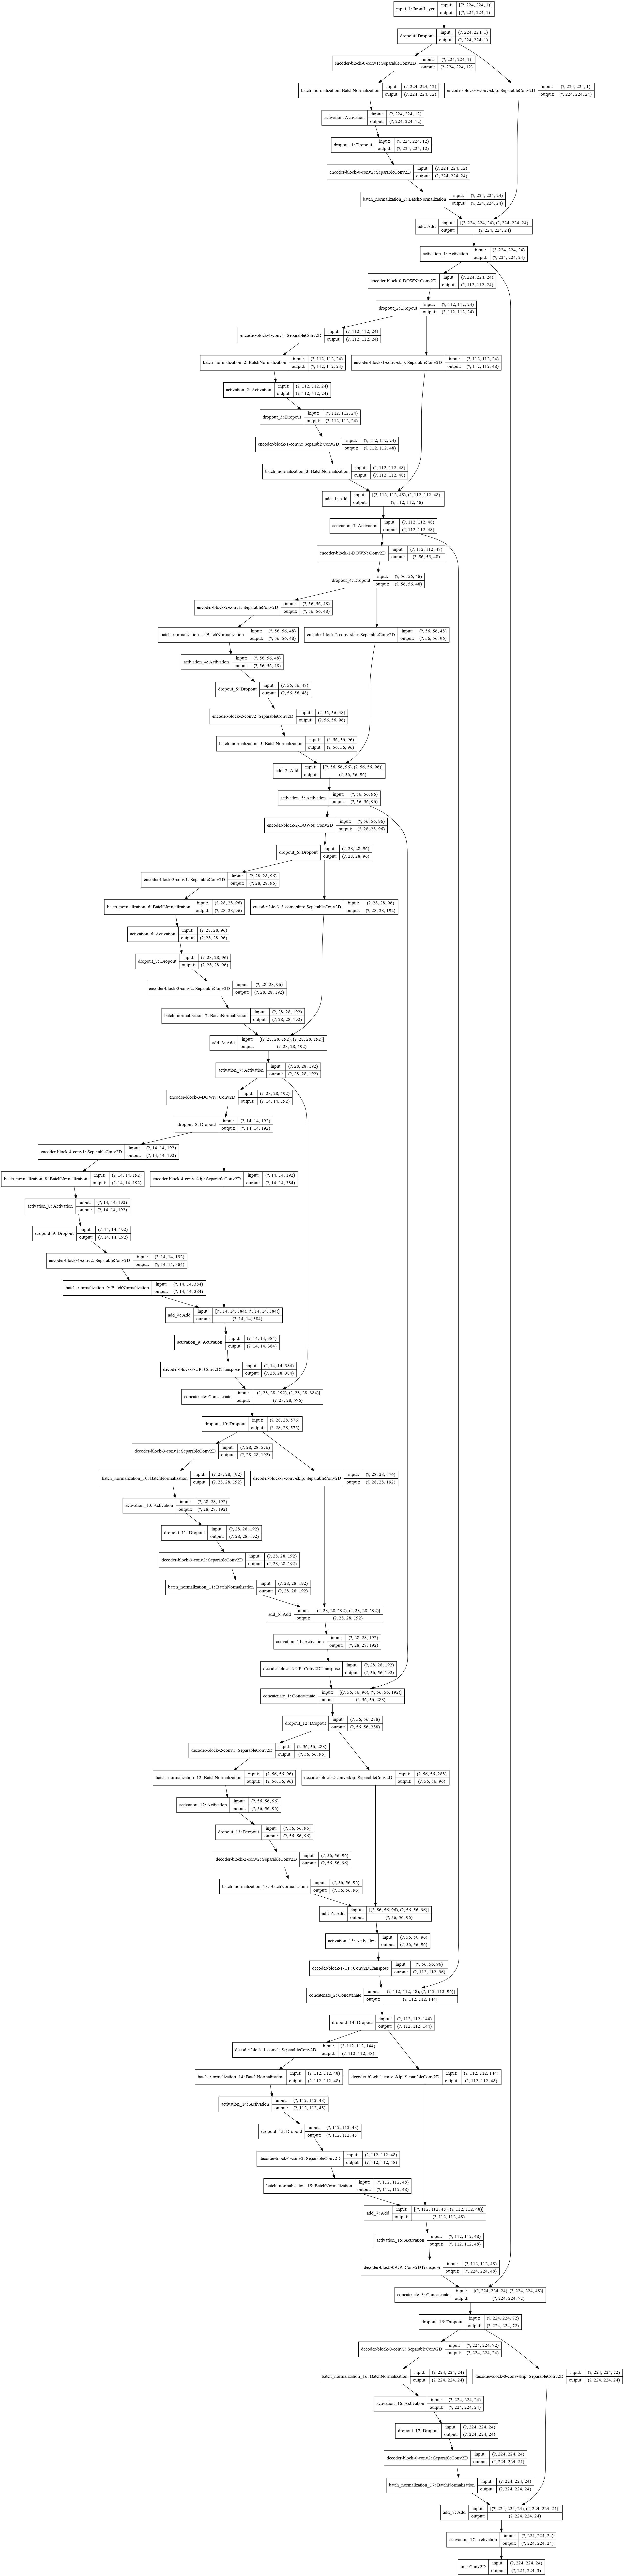

In [17]:
# write the model summary in a file
with model_paths.summary_path.open("w") as f:
    def print_to_txt(line):
        f.writelines([line + "\n"])
    model.summary(print_fn=print_to_txt, line_length=140)

# same for the architecture
utils.plot_model(model, show_shapes=True, to_file=model_paths.architecture_plot_path)

# todo add links to the files here

# Compilation

In [77]:
lr = 3e-3
n_epochs = 50
loss_func = losses.categorical_crossentropy
optimizer = optimizers.Adam(lr=lr)

cb = [
    callbacks.ModelCheckpoint(
        str(model_paths.autosaved_model_path), 
        monitor="val_loss", 
        verbose=0, 
        save_best_only=True, 
        mode="auto",
    ),
    callbacks.CSVLogger(str(model_paths.logger_path), separator=",", append=False),
    callbacks.TerminateOnNaN(),
    # todo use plateau lr reduction
    # ReduceLROnPlateauBacktrack(
    #     model,
    #     autosave_model_file_path,
    #     monitor="val_loss",
    #     factor=0.5,
    #     patience=5,
    #     verbose=1,
    #     mode="auto",
    #     min_delta=0,
    #     min_lr=1e-5,
    # ),
]

# todo add to summary
run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom=True)

In [78]:
# unique, counts = np.unique(train_labels, return_counts=True)
# class_freqs = dict(zip(unique, counts))
# total = sum(class_freqs.values())
# class_freqs = {k: v / total for k, v in class_freqs.items()}
# class_freqs
# class_freqs_inv = {k: 1. / v for k, v in class_freqs.items()}
# class_freqs_inv
# import tensorflow as tf
# from tensorflow.python.keras import backend as K
# weights = [class_freqs_inv[i] for i in range(len(class_freqs_inv))]

# def weighted_cross_entropy(y_true, y_pred):
#   Kweights = K.constant(weights)
#   if not K.is_keras_tensor(y_pred):
#     y_pred = K.constant(y_pred)
#   y_true = K.cast(y_true, y_pred.dtype)
#   return K.categorical_crossentropy(y_true, y_pred) * K.sum(y_true * y_pred, axis=-1)

In [79]:
model.compile(loss=loss_func, optimizer=optimizer)
model.save(model_paths.model_path)

INFO:tensorflow:Assets written to: /home/users/jcasagrande/projects/tomo2seg/models/dryrun-02/assets


# Summary before training

In [80]:
# stuff that i use after the training but i want it to appear in the 
# pre-training summary

In [81]:
# todo also print to a file
# todo plot image samples here
metadata = Metadata.build(
    model, model_paths, 
    volume_paths, train_generator, val_generator,
    model_generator_function, nb_filters_0, input_shape,
    n_epochs
)

print(yaml.dump(metadata, default_flow_style=False, indent=4))

!Metadata
architecture: !Architecture
    input_shape: (224, 224, 1)
    model_generator_function: tomo2seg.modular_unet.u_net
    n_params_nontrainable: 3672
    n_params_nontrainable_human: '3672'
    n_params_total: 2835009
    n_params_total_human: 2.8 million
    n_params_trainable: 2831337
    n_params_trainable_human: 2.8 million
    u_net__n_filters_0: 12
batch_size: 16
learning_rate: '3.00e-03'
loss_func: tensorflow.python.keras.losses.categorical_crossentropy
model_name: dryrun-02
n_batches_per_epoch: 500
n_epochs: 50
n_examples_per_epoch: 8000
n_examples_per_epoch_human: 8,000
optimizer: tensorflow.python.keras.optimizer_v2.adam.Adam
paths: !Paths
    architecture_fig: /home/users/jcasagrande/projects/tomo2seg/models/dryrun-02/summary.txt
    autosave: /home/users/jcasagrande/projects/tomo2seg/models/dryrun-02-autosaved
    history_csv: null
    logger: /home/users/jcasagrande/projects/tomo2seg/models/dryrun-02/logger.csv
    model: /home/users/jcasagrande/projects/tomo2seg/

# Training


In [82]:
raise Exception('stop')  # avoid launching the train before taking a look above

Exception: stop

In [83]:
history = model.fit(
    x=train_generator,
    validation_data=val_generator,
    validation_steps=20,  # todo put in summary
    epochs=n_epochs,
    callbacks=cb,  # todo mention in summary...
    verbose=1,
    use_multiprocessing=False,   # todo add to summary
    # class_weight=class_freqs_inv,  # todo better with actual images !!!!!!!!!!!!!!!!!!!!!
)

Epoch 1/50
500/500 [==============================] - 470s 941ms/step - loss: 0.0101 - val_loss: 0.2171
Epoch 2/50
500/500 [==============================] - 451s 902ms/step - loss: 0.0073 - val_loss: 0.2756
Epoch 3/50
500/500 [==============================] - 453s 907ms/step - loss: 0.0055 - val_loss: 0.3189
Epoch 4/50
500/500 [==============================] - 443s 886ms/step - loss: 0.0053 - val_loss: 0.3796
Epoch 5/50
500/500 [==============================] - 442s 884ms/step - loss: 0.0052 - val_loss: 0.3698
Epoch 6/50
500/500 [==============================] - 438s 876ms/step - loss: 0.0047 - val_loss: 0.3430
Epoch 7/50
500/500 [==============================] - 441s 881ms/step - loss: 0.0045 - val_loss: 0.3619
Epoch 8/50
500/500 [==============================] - 443s 887ms/step - loss: 0.0041 - val_loss: 0.4397
Epoch 9/50
500/500 [==============================] - 441s 882ms/step - loss: 0.0040 - val_loss: 0.4027
Epoch 10/50
500/500 [==============================] - 439s 879m

# Analyze training


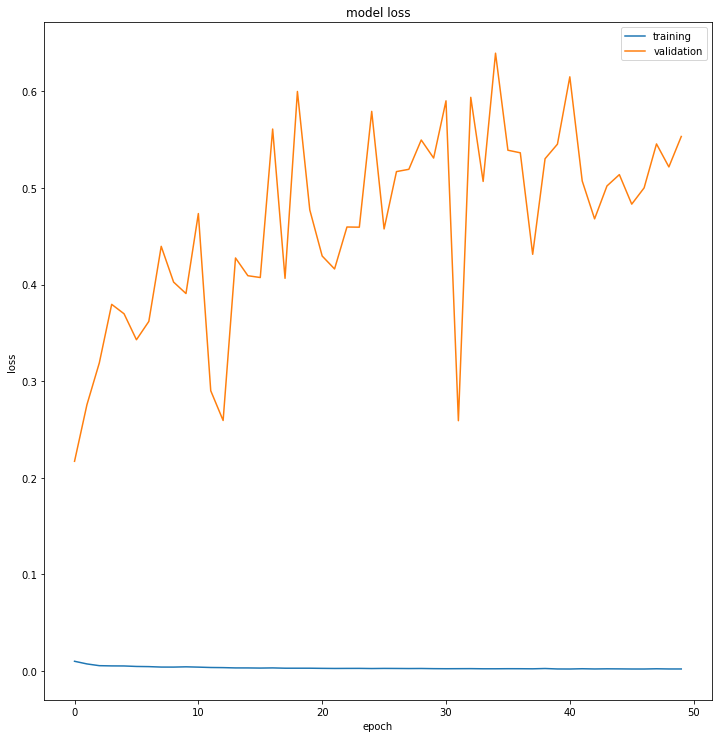

In [84]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 111)

In [85]:
history_df = pd.DataFrame({**history.history, **{"epochs": history.epoch}})
history_df.to_csv(history_csv_path, index=False)

In [88]:
model.save(model_paths.model_path)

INFO:tensorflow:Assets written to: /home/users/jcasagrande/projects/tomo2seg/models/dryrun-02/assets


In [89]:
# todo add metrics 
# todo add wandb?
# todo add analysis in the end, see examples of classif
# todo add callbacks that generate classif examples
# todo print line that I can cccv on the experiments spreadsheet
# todo save the yaml file
# todo (later): separate the analysis part in a separate script so it 
#  can be called at any time with another model